# Deep Convolutional Generative Adversarial Network (DCGAN)

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

import os
import time
from os import path
from matplotlib import pyplot as plt

import datetime

from Generator import makeGenerator
from Discriminator import makeDiscriminator
import numpy as np

from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import pathlib

## create train and validation datasets
BUFFER_SIZE = 10000
BATCH_SIZE = 64
IMG_WIDTH = 128
IMG_HEIGHT = 128
latent_dim = 100

## Loading and Preparing Data

In [2]:
DB_PATH = "G:\\Datasets\\BIKED\\bike256"

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)

    input_image = tf.cast(image, tf.float32)
    return input_image

def resize(input_image):
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

def normalize(input_image):
    input_image = (input_image / 127.5) - 1
    return input_image

def load_images(image_file):
    input_image = load(image_file)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image


data_dir = pathlib.Path(DB_PATH)
dataset = tf.data.Dataset.list_files(DB_PATH+'\\*.jpg')

image_count = len(list(dataset))
val_size = int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

print("Total_images:"+str(image_count))
print("Training_images:"+str(len(list(train_ds))))
print("Validation images:"+str(len(list(val_ds))))

train_ds = train_ds.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_ds = val_ds.map(load_images)
val_ds = val_ds.batch(BATCH_SIZE)


Total_images:4510
Training_images:3608
Validation images:902


## Viewing Images

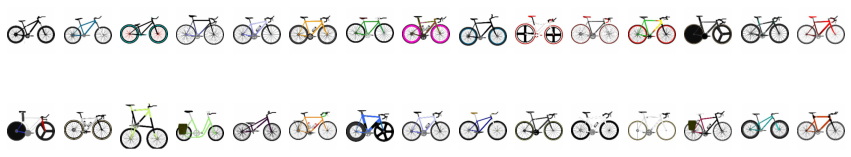

In [3]:
plt.figure(figsize=(15, 5))
for images in val_ds.take(1):
    for i in range(30):
      ax = plt.subplot(3, 15, i + 1)
      img = 0.5*images[i].numpy().astype("float32") + 0.5
      plt.imshow(img)
      plt.axis("off")
        

## Building Generator and Discriminator

In [4]:
generator = makeGenerator()
generator.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 16384)             1654784   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
sequential (Sequential)      (None, 16, 16, 128)       524800    
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 64)        131328    
_________________________________________________________________
sequential_2 (Sequential)    (None, 64, 64, 32)        32896     
_________________________________________________________________
sequential_3 (Sequential)    (None, 128, 128, 16)      8256  

In [6]:

discriminator = makeDiscriminator()
discriminator.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        3072      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       131072    
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0   

## Compiling Models

In [ ]:

#gan_optimizer = Adam(2e-4, 0.5)
#generator.compile(loss='binary_crossentropy',optimizer=gen_optimizer,metrics=None)

disc_optimizer = Adam(0.00005, 0.5)
discriminator.compile(loss='binary_crossentropy',optimizer=disc_optimizer,metrics=None)

# Building a Combined adversarial Network with discriminator untrainable (i.e. only for decision making)
discriminator.trainable = False
gan = tf.keras.Sequential()
gan.add(generator)
gan.add(discriminator)
gan_optimizer = Adam(2e-4, 0.5)
gan.compile(loss='binary_crossentropy',optimizer=gan_optimizer,metrics=None)
gan.summary()

## Training

In [ ]:


def train_step(imgs,gen_imgs):
        
        # Ground Truths
        num_imgs = imgs.shape[0]
        real_y = np.ones((num_imgs, 1)) - np.random.random_sample((num_imgs,1)) * 0.1  # Giving generator some room to breathe
        fake_y = np.random.random_sample(num_imgs) * 0.1                    
        
        
        # Allowing the discriminator to train
        discriminator.trainable = True
        
        # Training the Discriminator
        loss_real = discriminator.train_on_batch(imgs, real_y)
        loss_fake = discriminator.train_on_batch(gen_imgs, fake_y)
        disc_loss = loss_real + loss_fake
        
        # Shutting down discriminator for training the generator
        discriminator.trainable = False
        
        # Training the Generator
        latent_noise = np.random.normal(0, 1, (num_imgs, latent_dim))
        fake_y = np.ones((num_imgs, 1)) - np.random.random_sample((num_imgs,1)) * 0.1    # trying to fool the discriminator
        adv_loss = gan.train_on_batch(latent_noise, fake_y)
        
        return [adv_loss,disc_loss]
        

In [ ]:
from IPython import display

def save_snapshot(fake,fig,fname):
    
    for i in range(100):
        ax = fig.add_subplot(10,10, i+1)
        ax.axis('off')
        gen_imgs = (0.5*fake[i,:,:,:]+0.5) * 255
        gen_imgs = np.array(gen_imgs)  
        gen_imgs = gen_imgs.astype(np.uint8)
        ax.imshow(gen_imgs)
    display.display(fig)
    fig.savefig(fname)

In [ ]:
losses = {"adv_loss":[],"disc_loss":[]}

checkpoint = tf.train.Checkpoint(generator_optimizer=gan_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

def fit(train_ds, start_epoch ,epochs):
    
    
    for epoch in range(start_epoch,epochs):
        start = time.time()

        
        print("Epoch: ", epoch)

        for n, input_imgs in train_ds.enumerate():
            
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            latent_noise = np.random.normal(0, 1, (input_imgs.shape[0], latent_dim))
            gen_imgs = generator.predict(latent_noise)
            loss = train_step(input_imgs,gen_imgs)
            
        print()
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = "./checkpoints/ckpt")
            fig = plt.figure(figsize=(20, 10))
            latent = np.random.normal(0, 1, (100, latent_dim))
            fake = generator.predict(latent)
            save_snapshot(fake,fig,"./checkpoints/snap"+str(epoch)+".jpg")
            
        
        
        print ("[Adv loss: %f] [Disc loss: %f]" % (loss[0], loss[1]))
        losses["adv_loss"].append(loss[0])
        losses["disc_loss"].append(loss[1])
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
        

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint("./checkpoints"))
if(path.exists("gan_bicycles.h5")):
    generator.load_weights("gan_bicycles.h5")
else:
    fit(train_ds,0,250)
    generator.save_weights("gan_bicycles.h5")

## Plotting Losses

In [ ]:
plt.plot(losses["adv_loss"],label='adv_loss')
plt.plot(losses["disc_loss"],label='disc_loss')


## Results

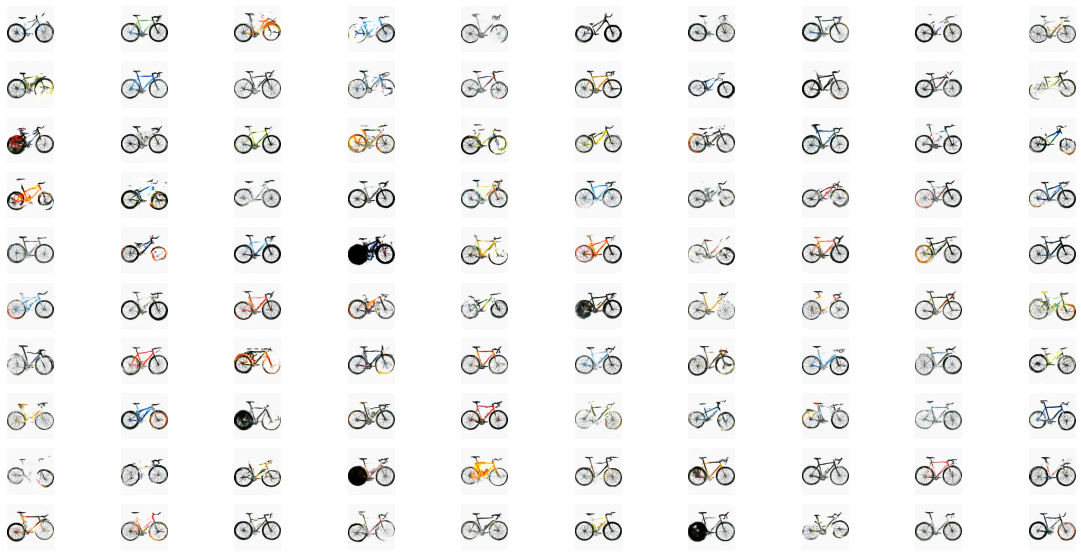

<Figure size 1080x360 with 0 Axes>

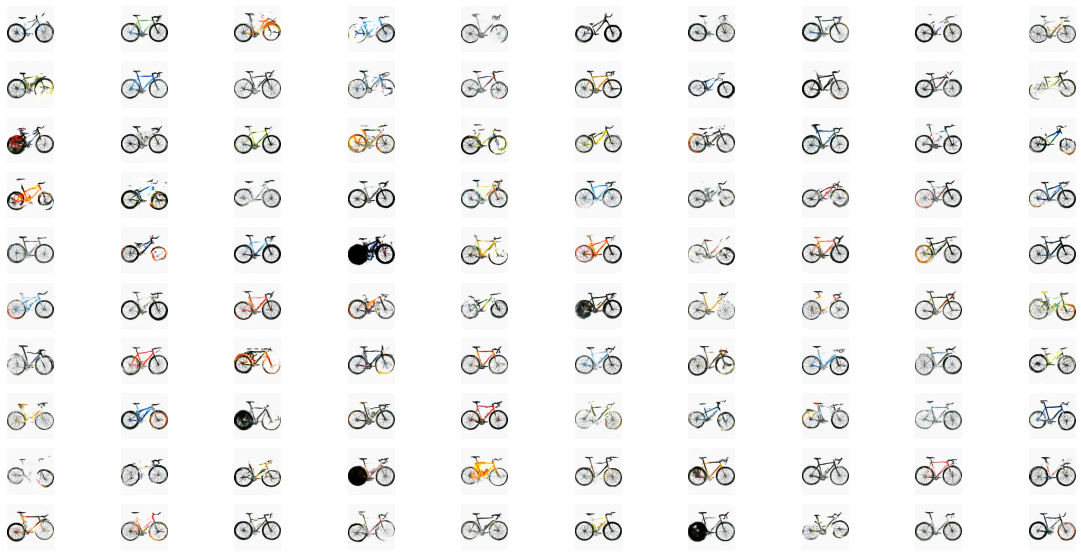

In [31]:
fig = plt.figure(figsize=(15, 5))

latent_space = np.random.normal(0, 1, (100, latent_dim))
fake = generator.predict(latent_space)
fig = plt.figure(figsize=(20, 10))
save_snapshot(fake,fig,"bicycles.jpg")


## Interpolating Latent Vectors

In [40]:
import random

# Interpolate between 2 bicycles picked randomly from the latent space
def get_interp_vect(latent_space):
    x1 = latent_space[random.randrange(0,latent_space.shape[0]),:]
    x2 = latent_space[random.randrange(0,latent_space.shape[0]),:]
    X = np.linspace(x1,x2,1000)
    X = X[range(0,1000,100),:]
    return X

def gen_images(latent_space):
    X = np.zeros((50,latent_dim))
    for i in range(0,50,10):
        X[i:i+10,:] = get_interp_vect(latent_space)
    generated = generator.predict(X)


    fig = plt.figure(figsize=(15, 7))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    n = 1
    for i in range(0,50,1):
        ax = fig.add_subplot(5, 10, n)
        n = n + 1
        ax.axis('off')
        pred = (0.5*generated[i, :, :, :]+0.5) * 255
        pred = np.array(pred)  
        pred = pred.astype(np.uint8)
        ax.imshow(pred)
    

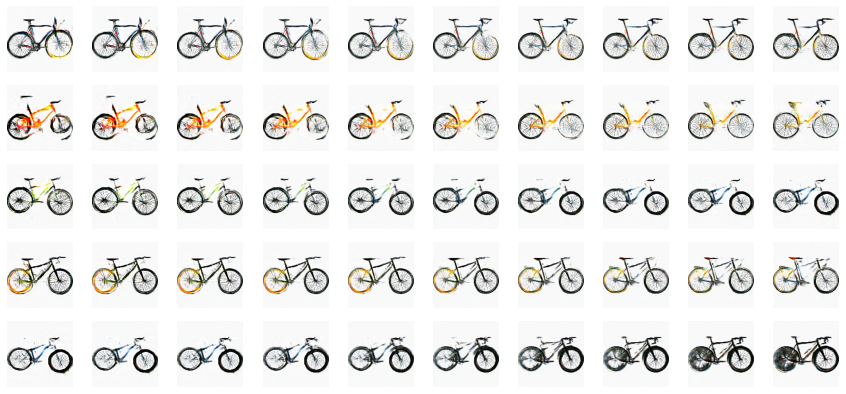

In [41]:
gen_images(latent_space)